In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [154]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Define Cosine Smilarity Function

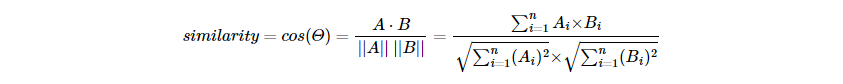

In [3]:
def cos_sim(x, y):
    # x, y의 내적의 곱을 x, y의 거리를 곱한 값으로 나누어준다.
    cs = np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return cs

# Data Visualization

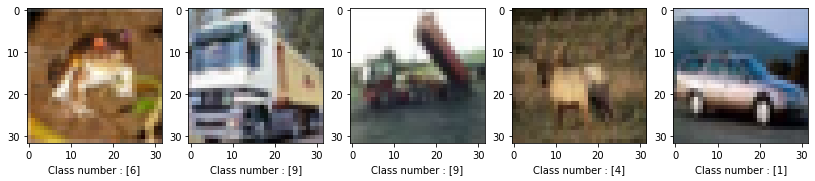

(50000, 32, 32, 3)

In [36]:
plt.figure(figsize=(14, 12))

for i in range(1):
    for j in range(5):
        plt.subplot(1, 5, i+j+1)
        plt.imshow(X_train[j])
        plt.xlabel('Class number : {}'.format(y_train[j]))
        plt.grid(False)
        
plt.show()

X_train.shape

# Get embedding model

In [99]:
mobile = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, 
                                           weights='imagenet', classifier_activation=None)

In [100]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [101]:
mobile.trainable = False

# Embedding model fine tuning 

In [120]:
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
gap_layer = tf.keras.layers.GlobalAveragePooling2D()
fc1 = tf.keras.layers.Dense(512, activation='relu')
fc2 = tf.keras.layers.Dense(10)

x = mobile(input_layer)
x = gap_layer(x)
x = fc1(x)
output = fc2(x)

embedding_model = tf.keras.Model(inputs=input_layer, outputs=output)

In [121]:
embedding_model.summary()

Model: "functional_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 2,918,986
Trainable params: 661,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [122]:
embedding_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), 
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(True), 
                        metrics=['accuracy'])

# Define Dataloader

In [123]:
def read_train_preprocessing(train_image, label):
    train_image = tf.image.resize(train_image, (224, 224))
    train_image = (tf.cast(train_image, dtype = tf.float32) - 127.5) / 127.5
    
    rotated = tf.random.uniform((), 0, 3, dtype=tf.int32)
    
    if tf.random.uniform(()) > 0.5:
        train_image = tf.image.flip_left_right(train_image)
        
    if tf.random.uniform(()) > 0.5:
        train_image = tf.image.flip_up_down(train_image)
        
    if rotated == 0:
        train_image = tf.image.rot90(train_image, k=1)
    elif rotated == 1:
        train_image = tf.image.rot90(train_image, k=2)
    elif rotated == 2:
        train_image = tf.image.rot90(train_image, k=3)
        
    train_image = tf.image.random_brightness(train_image, 0.2)
    
    return train_image, tf.squeeze(label)

In [124]:
GLOBAL_BATCHSIZE = 1

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(read_train_preprocessing)
train_dataset = train_dataset.batch(GLOBAL_BATCHSIZE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for i, j in train_dataset.take(1):
    print(i.shape, j.shape)

(1, 224, 224, 3) (1,)


# Model training

In [125]:
STEPS_PER_EPOCH = len(X_train) // GLOBAL_BATCHSIZE

history = embedding_model.fit(train_dataset, epochs=10, batch_size=1, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/10
50000/50000 [==============================] - 433s 9ms/step - loss: 0.9896 - accuracy: 0.6541
Epoch 2/10
50000/50000 [==============================] - 436s 9ms/step - loss: 0.8566 - accuracy: 0.7032
Epoch 3/10
50000/50000 [==============================] - 435s 9ms/step - loss: 0.8226 - accuracy: 0.7150
Epoch 4/10
50000/50000 [==============================] - 431s 9ms/step - loss: 0.8036 - accuracy: 0.7259
Epoch 5/10
50000/50000 [==============================] - 432s 9ms/step - loss: 0.7963 - accuracy: 0.7284
Epoch 6/10
50000/50000 [==============================] - 437s 9ms/step - loss: 0.7850 - accuracy: 0.7321
Epoch 7/10
50000/50000 [==============================] - 429s 9ms/step - loss: 0.7823 - accuracy: 0.7344
Epoch 8/10
50000/50000 [==============================] - 429s 9ms/step - loss: 0.7740 - accuracy: 0.7398
Epoch 9/10
50000/50000 [==============================] - 430s 9ms/step - loss: 0.7731 - accuracy: 0.7435
Epoch 10/10
50000/50000 [=====================

In [151]:
trained_embedding_model = tf.keras.Model(inputs=input_layer, outputs=x)

# Target Visualization

In [155]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [156]:
target, target_label, target_name = tf.image.resize(X_train[2030], (224, 224)), y_train[2030], class_names[int(y_train[2030])]

class num :  [7] class name :  horse


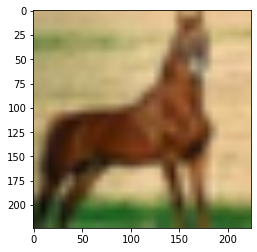

In [157]:
plt.imshow(tf.cast(target, dtype=tf.int32))

print('class num : ', target_label, 'class name : ', target_name)

# Preprocessing

In [158]:
target = (target - 127.5) / 127.5

target_pred = trained_embedding_model(tf.expand_dims(target, axis=0))
target_pred = tf.squeeze(target_pred)

target_pred.shape, target_label, target_name

(TensorShape([512]), array([7], dtype=uint8), 'horse')

In [159]:
X_test_sample = X_test[::45]
y_test_sample = y_test[::45]

X_test_sample.shape, y_test_sample.shape

((223, 32, 32, 3), (223, 1))

In [160]:
pred_sample, sample_label, sample_name = [], [], []

for i in range(X_test_sample.shape[0]):
    pre_img = (tf.image.resize(X_test_sample[i], (224, 224)) - 127.5) / 127.5
    pred_sample.append(tf.squeeze(trained_embedding_model(tf.expand_dims(pre_img, axis=0))))
    sample_label.append(y_test_sample[i])
    sample_name.append(class_names[int(y_test_sample[i])])

In [161]:
len(pred_sample), len(sample_label), len(sample_name)

(223, 223, 223)

# Calculate Similarity

In [162]:
sim_list = []

for i, proba in enumerate(pred_sample):
    # 7의 class를 갖는 vector와 비교
    cs = cos_sim(target_pred, proba)
    sim_list.append([cs, sample_label[i], sample_name[i]])

In [165]:
sorted(sim_list, reverse=True)

[[0.87560207, array([7], dtype=uint8), 'horse'],
 [0.819511, array([7], dtype=uint8), 'horse'],
 [0.8151975, array([7], dtype=uint8), 'horse'],
 [0.81075513, array([7], dtype=uint8), 'horse'],
 [0.81057245, array([7], dtype=uint8), 'horse'],
 [0.74805427, array([7], dtype=uint8), 'horse'],
 [0.7297334, array([7], dtype=uint8), 'horse'],
 [0.70089275, array([7], dtype=uint8), 'horse'],
 [0.6846882, array([7], dtype=uint8), 'horse'],
 [0.67212206, array([7], dtype=uint8), 'horse'],
 [0.6690945, array([7], dtype=uint8), 'horse'],
 [0.66168195, array([7], dtype=uint8), 'horse'],
 [0.6577107, array([7], dtype=uint8), 'horse'],
 [0.65688044, array([7], dtype=uint8), 'horse'],
 [0.6295791, array([7], dtype=uint8), 'horse'],
 [0.6069822, array([7], dtype=uint8), 'horse'],
 [0.6003496, array([4], dtype=uint8), 'deer'],
 [0.5949345, array([7], dtype=uint8), 'horse'],
 [0.59096813, array([4], dtype=uint8), 'deer'],
 [0.5778706, array([7], dtype=uint8), 'horse'],
 [0.57497877, array([7], dtype=uin